In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from datetime import *
from sklearn.ensemble import RandomForestClassifier
import time

In [155]:
ds_service = "train_service.csv"
df_service = pd.read_csv(ds_service, parse_dates=['registerdate','enddate'], infer_datetime_format=True)
df_service['gender'] = df_service['gender'].fillna('N')
df_service['agegroup'] = df_service['agegroup'].replace(950, 0)
df_service.loc[(df_service['pgamount'] <  100), 'pgamount'] = df_service['pgamount'] * 1120
df_service = df_service.fillna('X')
df_service.Repurchase = np.where(df_service.Repurchase == 'X', 1, 0)

In [158]:
ds_bookmark = "train_bookmark.csv"
df_bookmark = pd.read_csv(ds_bookmark, parse_dates=['dates'], infer_datetime_format=True)
df_bookmark.dates = df_bookmark.apply(lambda row: pd.Timestamp(datetime.combine(datetime.date(row['dates']),datetime.strptime(str(row['hour']),'%H').time())),axis=1)
df_bookmark = pd.merge(left=df_bookmark,right=df_service,how='left',on='uno')
df_bookmark = df_bookmark.fillna('X')

In [137]:
df_coin = "coin.csv"
df_coin = pd.read_csv(df_coin, parse_dates=['registerdate'], infer_datetime_format=True)
df_coin = pd.merge(left=df_coin,right=df_service,how='inner',on='uno')
df_coin = df_coin.fillna('X')

In [ ]:
df_missing = df_bookmark
np.sum(df_missing.isnull())
missing_number = df_missing.isnull().sum().sort_values(ascending=False)
missing_percentage = missing_number/len(df_missing)
missing_info = pd.concat([missing_number,missing_percentage],  axis=1, keys=['missing number','missing percentage'])
missing_info.head(50)

In [75]:
df_T = df_bookmark
# Encoding categorical variables to numeric ones

# Label 컬럼은 직접 변환
print('Repurchase = ', df_T.Repurchase.unique().tolist())
print(df_T.Repurchase.value_counts())
df_T['CHURN'] = np.where(df_T.Repurchase == 'X', 1, 0)   # 재결제('O') -> Churn Negative(0), 미결제('X') -> Churn Positive(1)
print('CHURN = ', df_T.CHURN.unique().tolist())
print(df_T.CHURN.value_counts())

# 이외 컬럼들은 일괄 자동 변환
col_lst = df_T.columns.values.tolist()
col_lst.remove('uno')
col_lst.remove('productcode')
for c in col_lst:
    if df_T[c].dtype == 'object':
        print(c)
        lbl = LabelEncoder()
        lbl.fit(list(df_T[c].values))
        df_T[c] = lbl.transform(df_T[c].values)
df_T.sample(5)

Repurchase =  [1, 0]
0    5703378
1    2193845
Name: Repurchase, dtype: int64
CHURN =  

/Users/jiyeonseo/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


[0]
0    7897223
Name: CHURN, dtype: int64
programid
title
contentid
contentnumber
section
promo_100
coinReceived
devicetypeid
isauth
gender


,uno,dates,hour,channeltype,programid,title,contentid,contentnumber,section,viewtime,...,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,CHURN
5936899,3e881a62ae97f9c62a92eee45679050d757448051ecab4...,2021-03-02 01:00:00,1,3,5803,11358,137476,3064,0,1090,...,180,4,1,1,0,7,0,1,25,0
7794206,38389fc2a350bfc83fe6a3d985441ea12107cd2015f09b...,2021-03-25 16:00:00,8,3,1617,9167,19295,3713,8,70,...,180,4,0,1,1,0,0,0,20,0
1829906,1d2832f598790117be6d8e7f453b04377559de02215e9c...,2021-03-18 09:00:00,23,3,5941,2151,133453,2237,3,390,...,131,2,1,1,0,0,1,0,45,0
2263948,f764a00ce59df039ffb7193614a6f3ce2fd0de97bbf254...,2021-03-25 20:00:00,13,1,6359,1033,138090,4897,19,50,...,134,1,1,0,0,0,1,0,25,0
6387028,49f4e1f21fbf1a8d684b5de2bfdcb4110dea82f81f74e9...,2021-03-18 19:00:00,11,1,4337,1033,138090,4897,19,590,...,140,4,1,1,0,1,1,0,35,0


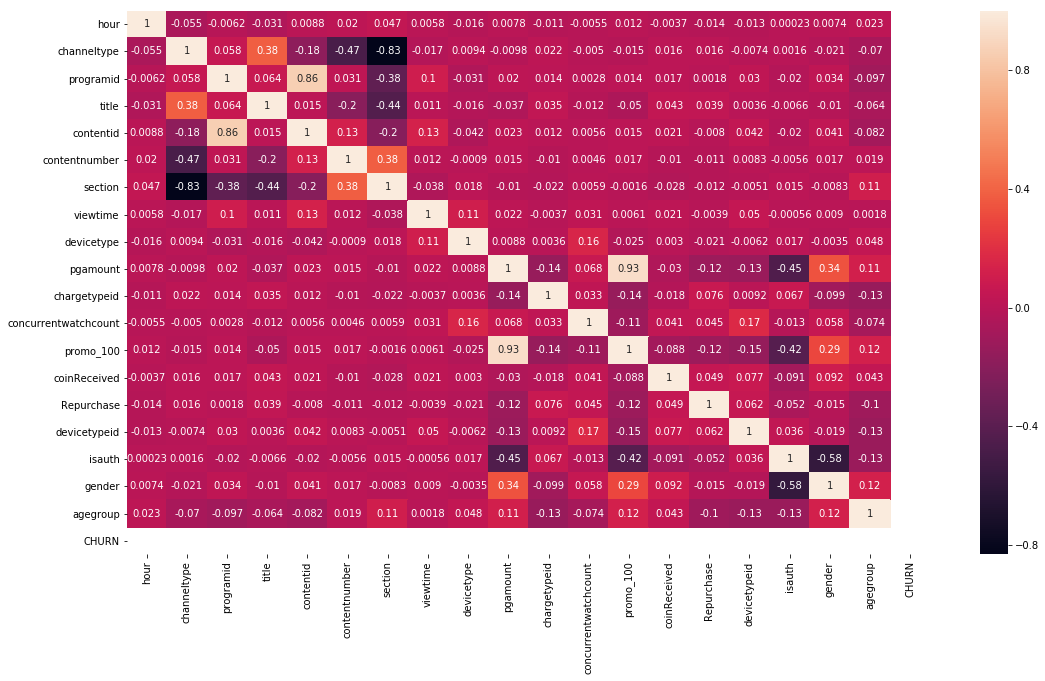

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(18,10))
sns.heatmap(df_bookmark.corr(), annot=True)   

In [154]:
X = df_T.drop(["dates","uno","registerdate","enddate","productcode","Repurchase","CHURN"], axis=1)
y = df_T["Repurchase"]

feature_names = X.columns.tolist()
forest = RandomForestClassifier(n_estimators=10,random_state=0)
forest.fit(X, y)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")


forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

KeyError: "['dates' 'registerdate' 'productcode'] not found in axis"

In [77]:
df_bookmark.corr()

,hour,channeltype,programid,title,contentid,contentnumber,section,viewtime,devicetype,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,CHURN
hour,1.000000,-0.055059,-0.006242,-0.031338,0.008823,0.020240,0.046649,0.005794,-0.015718,0.007782,-0.010847,-0.005549,0.011742,-0.003734,-0.013893,-0.012880,0.000228,0.007434,0.022616,NaN
channeltype,-0.055059,1.000000,0.058073,0.382125,-0.179900,-0.473840,-0.831170,-0.017377,0.009390,-0.009827,0.022190,-0.005008,-0.015460,0.015817,0.016461,-0.007423,0.001571,-0.020601,-0.070003,NaN
programid,-0.006242,0.058073,1.000000,0.063702,0.859415,0.030988,-0.377234,0.102986,-0.030712,0.020128,0.014004,0.002795,0.013661,0.016769,0.001791,0.030011,-0.019999,0.033524,-0.096583,NaN
title,-0.031338,0.382125,0.063702,1.000000,0.014904,-0.201638,-0.436960,0.010847,-0.015930,-0.036918,0.035473,-0.012069,-0.050403,0.042711,0.038941,0.003581,-0.006600,-0.010174,-0.063816,NaN
contentid,0.008823,-0.179900,0.859415,0.014904,1.000000,0.126198,-0.203739,0.132847,-0.042242,0.023167,0.012089,0.005593,0.015154,0.020944,-0.008030,0.041775,-0.020353,0.040514,-0.081883,NaN
contentnumber,0.020240,-0.473840,0.030988,-0.201638,0.126198,1.000000,0.383478,0.012313,-0.000902,0.014633,-0.010499,0.004555,0.017467,-0.010241,-0.011250,0.008254,-0.005580,0.017204,0.019120,NaN
section,0.046649,-0.831170,-0.377234,-0.436960,-0.203739,0.383478,1.000000,-0.037730,0.018354,-0.010189,-0.021517,0.005876,-0.001576,-0.027687,-0.011683,-0.005093,0.015444,-0.008335,0.106269,NaN
viewtime,0.005794,-0.017377,0.102986,0.010847,0.132847,0.012313,-0.037730,1.000000,0.107026,0.022126,-0.003735,0.031132,0.006145,0.021432,-0.003941,0.050068,-0.000564,0.009019,0.001833,NaN
devicetype,-0.015718,0.009390,-0.030712,-0.015930,-0.042242,-0.000902,0.018354,0.107026,1.000000,0.008837,0.003593,0.155615,-0.025187,0.003031,-0.021236,-0.006204,0.017345,-0.003470,0.048259,NaN
pgamount,0.007782,-0.009827,0.020128,-0.036918,0.023167,0.014633,-0.010189,0.022126,0.008837,1.000000,-0.139952,0.068276,0.932859,-0.030124,-0.121483,-0.128467,-0.451908,0.336763,0.113614,NaN


In [142]:
df_T = df_coin
# Encoding categorical variables to numeric ones

# Label 컬럼은 직접 변환
print('Repurchase = ', df_T.Repurchase.unique().tolist())
print(df_T.Repurchase.value_counts())
df_T['CHURN'] = np.where(df_T.Repurchase == 'X', 1, 0)   # 재결제('O') -> Churn Negative(0), 미결제('X') -> Churn Positive(1)
print('CHURN = ', df_T.CHURN.unique().tolist())
print(df_T.CHURN.value_counts())

# 이외 컬럼들은 일괄 자동 변환
col_lst = df_T.columns.values.tolist()
col_lst.remove('uno')

for c in col_lst:
    if df_T[c].dtype == 'object':
        print(c)
        lbl = LabelEncoder()
        lbl.fit(list(df_T[c].values))
        df_T[c] = lbl.transform(df_T[c].values)
df_T.sample(5)

Repurchase =  [0, 1]
0    6757
1    1957
Name: Repurchase, dtype: int64
CHURN =  [0]
0    8714
Name: CHURN, dtype: int64
productcode_x
productname
coinexpiredate
productcode_y
promo_100
coinReceived
devicetypeid
isauth
gender


/Users/jiyeonseo/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,uno,productcode_x,registerdate_x,paymenttypeid,currencytypeid,totalamount,pgamount_x,coinamount,bonusamount,discountamount,...,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,CHURN
4691,366a94af238753a6b4fb42191b40daf9bebc467903a665...,508,2021-03-12 16:36:00,9,1,-2500.0,0.0,-2500.0,0.0,0.0,...,132,1,1,1,0,0,1,0,35,0
4649,25bb3f056532a5f69c0e91bd498b085bddd71c6281bd3a...,83,2021-03-31 20:16:49,2,1,1500.0,0.0,1500.0,0.0,0.0,...,151,2,1,0,0,0,1,0,35,0
86,be39cfc743b32d7b3a88640d81431084853804ae5ba1e3...,8,2021-03-28 01:38:45,1,1,10000.0,0.0,0.0,10000.0,0.0,...,151,1,0,0,0,0,1,1,25,0
5066,37285e6792622fc6db90adebb012d0fbba811f1e8850e1...,8,2021-04-07 22:15:39,1,1,10000.0,0.0,0.0,10000.0,0.0,...,132,4,0,0,0,3,1,0,45,0
1246,76953c0ea823bf7e9cf79329f89901645c3f723d019d10...,8,2021-04-01 03:45:15,1,1,10000.0,0.0,0.0,10000.0,0.0,...,151,1,0,0,1,0,0,1,80,0


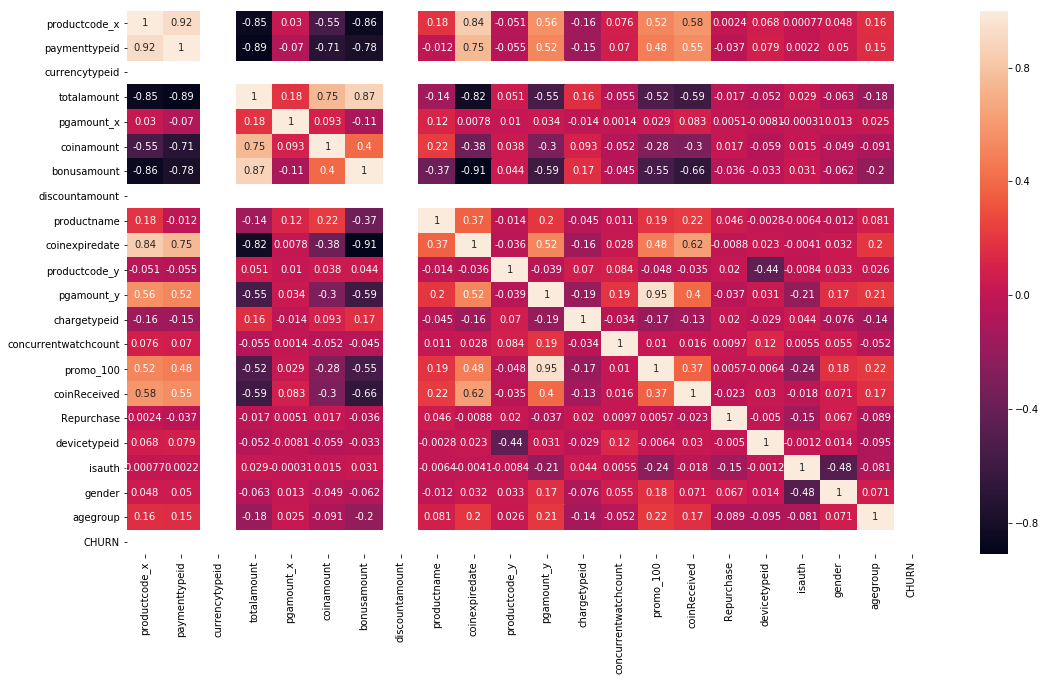

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(18,10))
sns.heatmap(df_coin.corr(), annot=True)   

In [145]:
df_coin.corr()

,productcode_x,paymenttypeid,currencytypeid,totalamount,pgamount_x,coinamount,bonusamount,discountamount,productname,coinexpiredate,...,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,CHURN
productcode_x,1.000000,0.922352,NaN,-0.854390,0.029871,-0.549955,-0.857515,NaN,0.181103,0.836182,...,-0.160467,0.075614,0.519597,0.584248,0.002433,0.067820,0.000766,0.047677,0.163444,NaN
paymenttypeid,0.922352,1.000000,NaN,-0.889816,-0.069750,-0.706540,-0.781153,NaN,-0.011635,0.748680,...,-0.149422,0.070462,0.482242,0.549850,-0.036836,0.079249,0.002197,0.050217,0.153556,NaN
currencytypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalamount,-0.854390,-0.889816,NaN,1.000000,0.184601,0.746702,0.874060,NaN,-0.142584,-0.821494,...,0.160829,-0.055454,-0.516888,-0.589899,-0.017271,-0.051889,0.029056,-0.063334,-0.180916,NaN
pgamount_x,0.029871,-0.069750,NaN,0.184601,1.000000,0.093184,-0.106611,NaN,0.117421,0.007830,...,-0.013530,0.001424,0.028749,0.082713,0.005071,-0.008123,-0.000305,0.012572,0.025441,NaN
coinamount,-0.549955,-0.706540,NaN,0.746702,0.093184,1.000000,0.398228,NaN,0.219919,-0.377653,...,0.093239,-0.052251,-0.282291,-0.301185,0.016780,-0.059259,0.015279,-0.049388,-0.091034,NaN
bonusamount,-0.857515,-0.781153,NaN,0.874060,-0.106611,0.398228,1.000000,NaN,-0.366373,-0.909679,...,0.170015,-0.045498,-0.552500,-0.658580,-0.035530,-0.033413,0.030994,-0.061527,-0.202709,NaN
discountamount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productname,0.181103,-0.011635,NaN,-0.142584,0.117421,0.219919,-0.366373,NaN,1.000000,0.369587,...,-0.044718,0.011391,0.185292,0.219345,0.046202,-0.002836,-0.006364,-0.012177,0.081327,NaN
coinexpiredate,0.836182,0.748680,NaN,-0.821494,0.007830,-0.377653,-0.909679,NaN,0.369587,1.000000,...,-0.160793,0.027534,0.480592,0.624407,-0.008846,0.023129,-0.004110,0.031633,0.200930,NaN


Elapsed time to compute the importances: 0.002 seconds


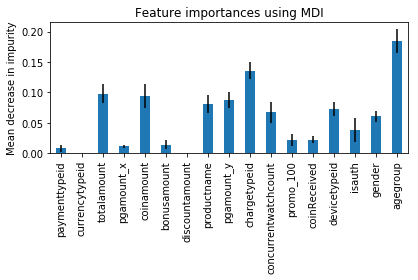

In [153]:
X = df_T.drop(["uno","coinexpiredate","registerdate_x","registerdate_y","enddate","productcode_x","productcode_y","Repurchase","CHURN"], axis=1)
y = df_T["Repurchase"]

feature_names = X.columns.tolist()
forest = RandomForestClassifier(n_estimators=10,random_state=0)
forest.fit(X, y)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")


forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


